In [10]:
import re
import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import math
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sqlalchemy import create_engine
import sqlite3
from collections import Counter
from ast import literal_eval


# Convert sql


In [ ]:
airbnb_data=pd.read_excel('D:\Python\HM_ML\Final Project\Dataset\hotel.xlsx')
airbnb_data = airbnb_data.loc[:, ~airbnb_data.columns.str.contains('^Unnamed')]
airbnb_data.columns

Index(['city', 'id', 'listing_url', 'name', 'description', 'picture_url',
       'latitude', 'longitude', 'room_type', 'bathrooms', 'bathrooms_text',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'review_scores_rating'],
      dtype='object')

In [ ]:
engine = create_engine('sqlite:///airbnb_data.db')
airbnb_data.to_sql('airbnb_data', con=engine, if_exists='replace', index=False)

56281

# EDA Data hotel

In [12]:
class Visualize:
    def __init__(self,database):
        self.database=database
        pass
    def query(self,sql):
        try:
            conn = sqlite3.connect(self.database)
            cursor = conn.cursor()
            cursor.execute(sql)
            rows = cursor.fetchall()
            columns = [desc[0] for desc in cursor.description]
            df = pd.DataFrame(rows, columns=columns)
            return df
        except Exception as e:
            print(f"An error occurred: {e}")
        finally:
            conn.close()
    def get_table_visualize(self):
        # Lấy dữ liệu từ các bảng khác nhau
        hotel_details = self.query('select * from airbnb_data')
        df_hotel_details = pd.DataFrame(hotel_details)
        # Xử lý dữ liệu
        df_hotel_details.dropna()
        df_hotel_details.drop_duplicates(subset='listing_id', keep=False, inplace=True)
        data_hotel = pd.DataFrame(df_hotel_details)
        # Loại bỏ các cột không cần thiết
        data_hotel.drop(columns=['listing_url', 'picture_url', 'latitude', 'longitude'], inplace=True)
        return data_hotel

    def visualize_airbnb_city(self):
        data_hotel = self.get_table_visualize()
        hotel_per_city = data_hotel.groupby('city')['listing_id'].count().to_dict()

        hotel_per_city = dict(sorted(hotel_per_city.items(), key=lambda x: x[1], reverse=True))

        # Prepare the data for the pie chart
        top_ten_city = list(map(str.capitalize, list(hotel_per_city.keys())[:5]))
        hotel_count1 = list(hotel_per_city.values())[:5]

        # Colors for the pie chart
        colors = ['#CD9575', '#665D1E', '#915C83', '#841B2D', '#FAEBD7', '#54626F', '#8DB600', '#00FFFF',
                  '#7FFFD4', '#4B5320']
        color1 = ['#0048BA', '#B0BF1A', '#7CB9E8', '#C0E8D5', '#B284BE', '#72A0C1', '#EDEAE0', '#BFFF00',
                  '#FE6F5E', '#EFDECD']

        # Plotting the pie chart
        fig, ax1 = plt.subplots(figsize=(10, 7), subplot_kw=dict(aspect="equal"))

        def make_val(all_values):
            def auto_pct(pct):
                val = int((pct * sum(all_values)) / 100)
                return f"{val}"
            return auto_pct

        wedges, texts, autotext = ax1.pie(x=hotel_count1, labels=top_ten_city, colors=color1, autopct=make_val(hotel_count1))

        plt.tight_layout()
        ax1.set_title('Top 5 cities with the highest number of airbnbs')
        plt.show()
    def city_visualize(self):
        df_visualize=self.query('select city from airbnb_data')
        plt.figure(figsize = (10,6))
        sns.barplot(x=df_visualize['city'].value_counts()[:5].index, y=df_visualize['city'].value_counts()[:5])
    def visualize_top_amenities(self, number):
        # Extract amenities from the given data
        df_amenities = self.query('select amenities from airbnb_data')
        df_amenities['amenities'] = df_amenities['amenities'].apply(ast.literal_eval)
        all_amenities = [item for sublist in df_amenities['amenities'] for item in sublist]
        
        # Count the occurrences of each amenity
        amenities_count = Counter(all_amenities)

        # Sort and get the top amenities
        top_amenities = amenities_count.most_common(number)

        print("Top {} amenities appearances :".format(number))
        for amenity, count in top_amenities:
            print("- {}: {}".format(amenity, count))
        
        # Unzip the top amenities and their counts
        amenities, counts = zip(*top_amenities)
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.barh(amenities, counts, color='skyblue')
        plt.xlabel('Number of appearances')
        plt.ylabel('Amenity')
        plt.title('Top {} Amenities appearances'.format(number))
        plt.gca().invert_yaxis() 
        plt.show()
    def categorize_price(self):
        data_hotel = self.get_table_visualize()
        if 'price' not in data_hotel.columns:
            print("The price column does not exist in the dataset.")
            return

        data_hotel['price'] = data_hotel['price'].replace('[\$,]', '', regex=True).astype(float)
        avg_price = data_hotel['price'].mean()

        low_threshold = avg_price / 2
        high_threshold = avg_price
        def price_category(price):
            if price < low_threshold:
                return 'Low'
            elif price < high_threshold:
                return 'Medium'
            else:
                return 'High'
        data_hotel['price_category'] = data_hotel['price'].apply(price_category)
                        # In các giá trị cụ thể của các khoảng giá
        print(f"Low price range: Below {low_threshold:.2f}")
        print(f"Medium price range: {low_threshold:.2f} to {high_threshold:.2f}")
        print(f"High price range: Above {high_threshold:.2f}")
        return data_hotel

    def visualize_price_categories(self):
        data_hotel = self.categorize_price()
        if data_hotel is None:
            return
        plt.figure(figsize=(10, 6))
        sns.countplot(data=data_hotel, x='price_category', palette='viridis')
        plt.title('Price Categories Distribution')
        plt.xlabel('Price Category')
        plt.ylabel('Count')
        plt.show()
    def visualize_city(self):
        data_hotel = self.query('select * from airbnb_data')
        hotel_per_city = data_hotel.groupby('city')['listing_id'].count().to_dict()
        hotel_per_city = dict(sorted(hotel_per_city.items(), key=lambda x: x[1], reverse=True))
        # Prepare the data for the pie chart
        top_ten_city = list(map(str.capitalize, list(hotel_per_city.keys())))
        hotel_count1 = list(hotel_per_city.values())

        # Colors for the pie chart
        colors = ['#CD9575', '#665D1E', '#915C83', '#841B2D', '#FAEBD7', '#54626F', '#8DB600', '#00FFFF',
                  '#7FFFD4', '#4B5320']
        color1 = ['#0048BA', '#B0BF1A', '#7CB9E8', '#C0E8D5', '#B284BE', '#72A0C1', '#EDEAE0', '#BFFF00',
                  '#FE6F5E', '#EFDECD']

        # Plotting the pie chart
        fig, ax1 = plt.subplots(figsize=(10, 7), subplot_kw=dict(aspect="equal"))

        def make_val(all_values):
            def auto_pct(pct):
                val = int((pct * sum(all_values)) / 100)
                return f"{val}"
            return auto_pct

        wedges, texts, autotext = ax1.pie(x=hotel_count1, labels=top_ten_city, colors=color1, autopct=make_val(hotel_count1))

        plt.tight_layout()
        ax1.set_title('Cities with number of airbnbs')
        plt.show()

In [7]:
database='airbnb_data.db'
vi=Visualize(database)

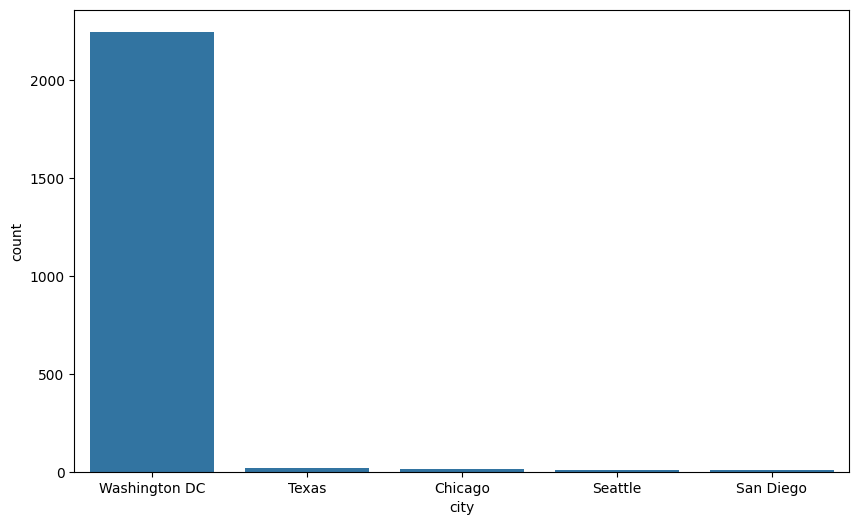

In [13]:
figure1=vi.city_visualize()

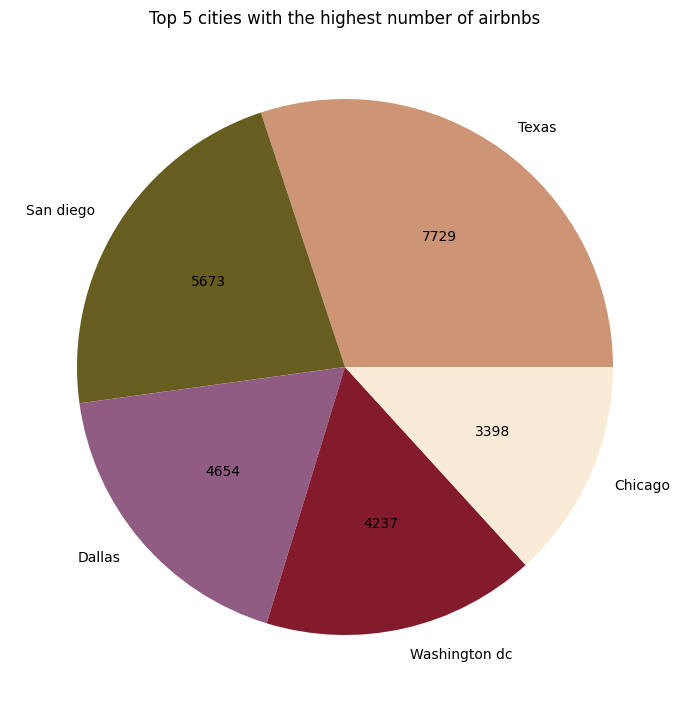

In [36]:
figure2=vi.visualize_airbnb_city()

Top 10 amenities appearances :
- Smoke alarm: 54451
- Kitchen: 51363
- Essentials: 49829
- Wifi: 49214
- Carbon monoxide alarm: 48893
- Hot water: 47298
- Hangers: 46261
- Hair dryer: 45489
- Dishes and silverware: 44510
- Microwave: 43578


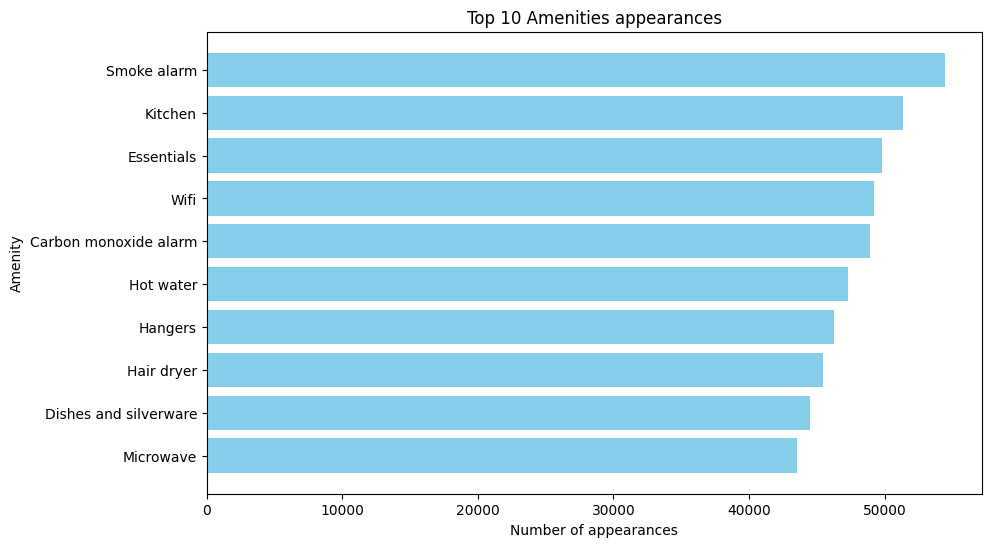

In [7]:
figure3=vi.visualize_top_amenities(10)        

Low price range: Below 110.46
Medium price range: 110.46 to 220.93
High price range: Above 220.93
Low price range: Below 110.46
Medium price range: 110.46 to 220.93
High price range: Above 220.93


C:\Users\hkhiy\AppData\Local\Temp\ipykernel_12384\3616607678.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_hotel, x='price_category', palette='viridis')


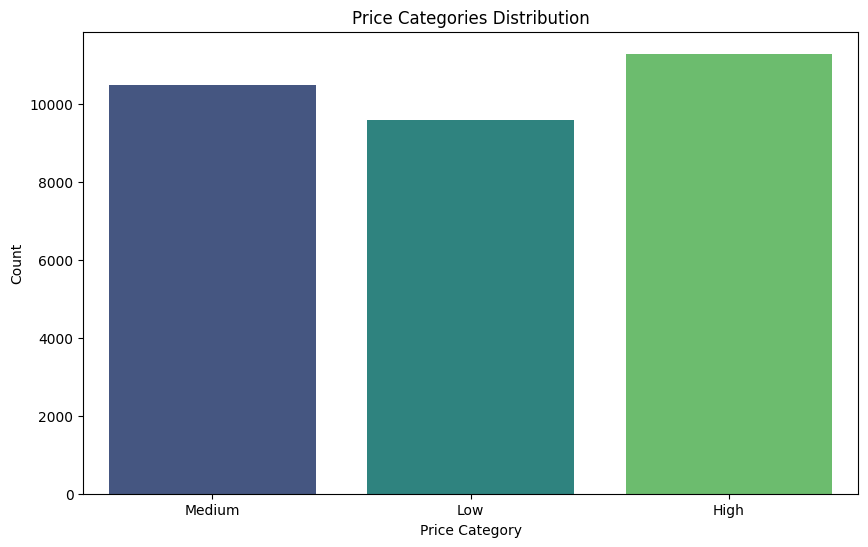

In [46]:
figure5=vi.categorize_price()
figure5=vi.visualize_price_categories()


In [8]:
figure6=vi.visualize_city()
figure6

An error occurred: name 'sqlite3' is not defined


UnboundLocalError: cannot access local variable 'conn' where it is not associated with a value